In [1]:
# from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# drive.mount('/content/drive')

Load Air Passengers data. The dataset provides monthly totals of a US airline passengers from 1949 to 1960.


In [3]:
df = pd.read_csv('AirPassengers.csv')

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Convert the `Month` column to datetime and set as the index.



In [6]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)

In [7]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Split into a training and testing set. We keep the two last years for testing.

In [8]:
train = df[df.index<pd.Timestamp(1959,1,1)]
test = df[df.index>=pd.Timestamp(1959,1,1)]

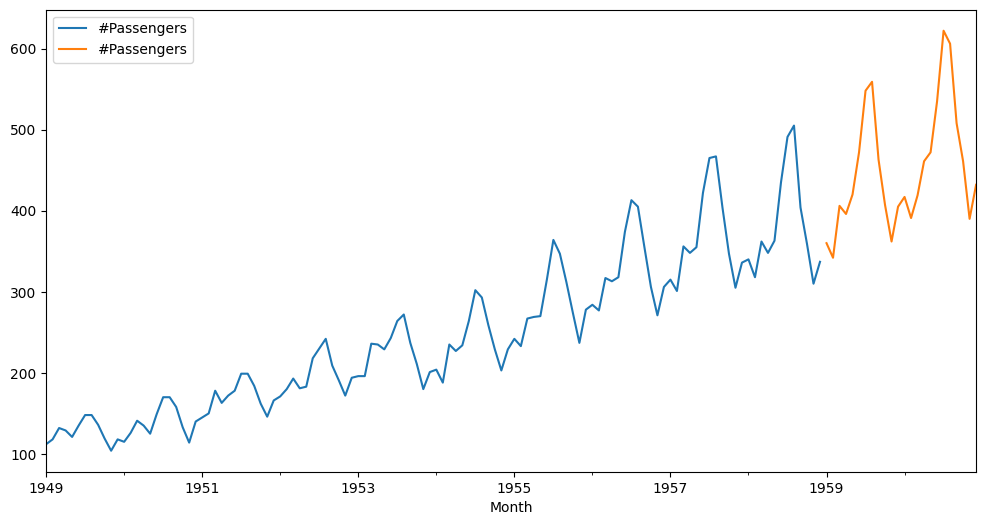

In [9]:
plt.rcParams['figure.figsize'] = 12,6
ax = train.plot();
test.plot(ax=ax);

Plot time series decomposition into trend, seasonality and residuals.

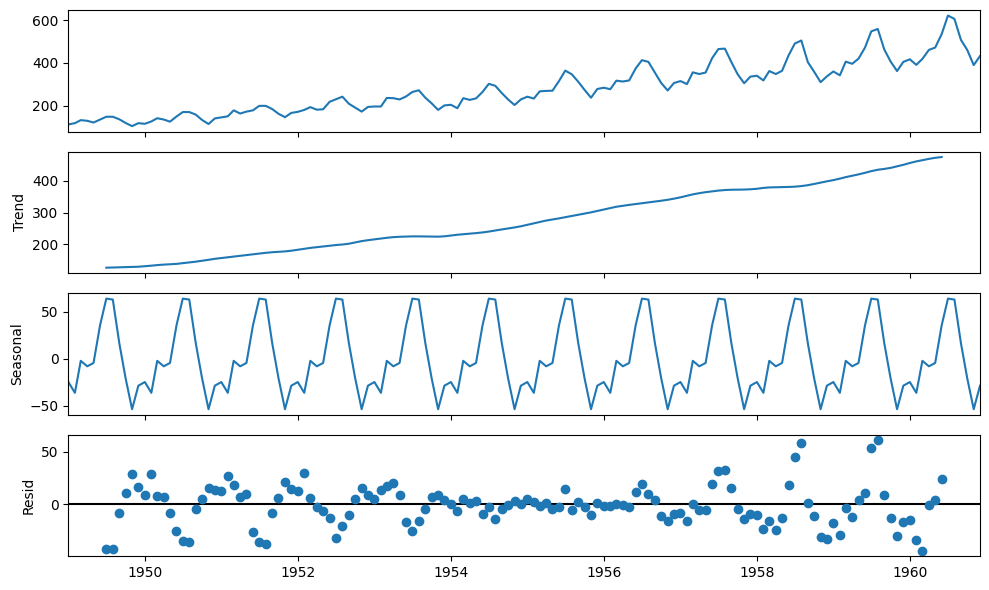

In [10]:
rcParams['figure.figsize'] = 10,6
result = seasonal_decompose(df)
result.plot();

We can check seasonality using the Augmented Dickey-Fuller test.


In [11]:
adf = adfuller(train)
print('ADF test statistic:', adf[0])
print('ADF p-values:', adf[1])
print('ADF number of lags used:', adf[2])
print('ADF number of observations:', adf[3])
print('ADF critical values:', adf[4])

ADF test statistic: -0.7734607708969236
ADF p-values: 0.8267937485032488
ADF number of lags used: 13
ADF number of observations: 106
ADF critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}


The time series is not stationary. Let's apply differencing.

In [12]:
diff1 = train.diff().dropna()

<Axes: xlabel='Month'>

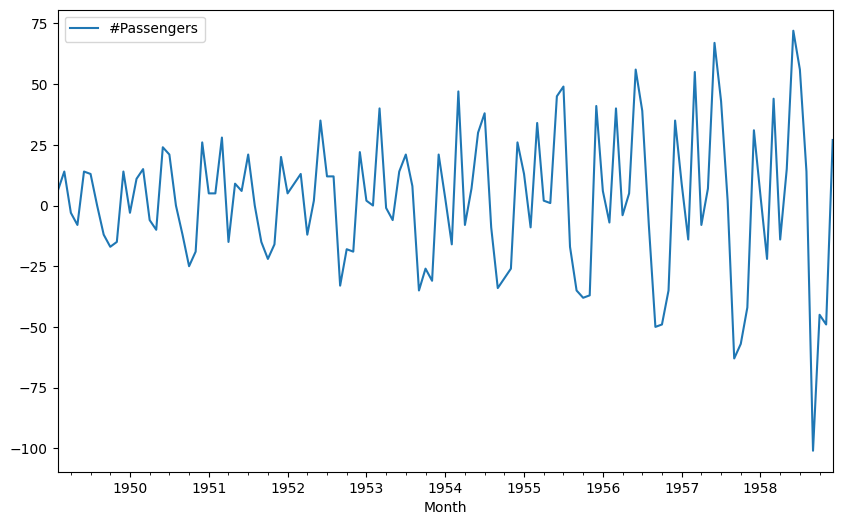

In [13]:
diff1.plot()

In [14]:
adf = adfuller(diff1)
print('ADF test statistic:', adf[0])
print('ADF p-values:', adf[1])
print('ADF number of lags used:', adf[2])
print('ADF number of observations:', adf[3])
print('ADF critical values:', adf[4])

ADF test statistic: -2.164143127804784
ADF p-values: 0.21951577637150388
ADF number of lags used: 12
ADF number of observations: 106
ADF critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}


The series are still not stationary, so we apply differencing again.


In [15]:
diff2 = diff1.diff().dropna()

<Axes: xlabel='Month'>

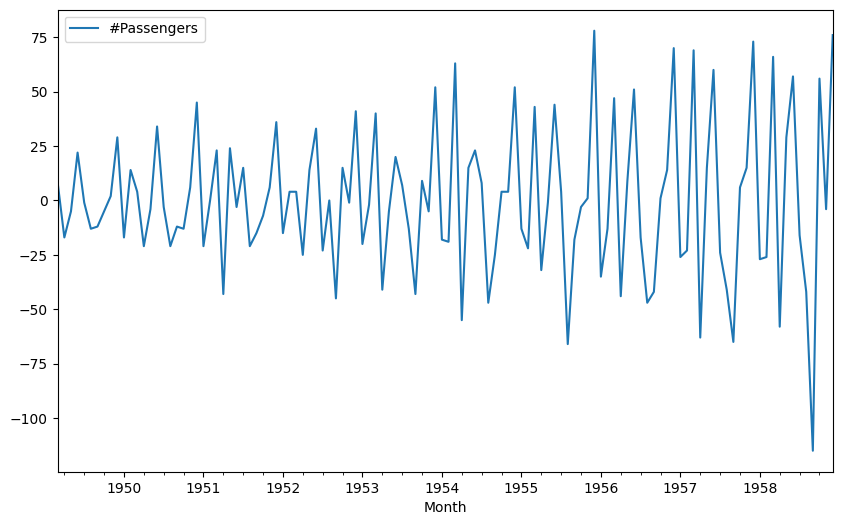

In [16]:
diff2.plot()

In [17]:
adf = adfuller(diff2)
print('ADF test statistic:', adf[0])
print('ADF p-values:', adf[1])
print('ADF number of lags used:', adf[2])
print('ADF number of observations:', adf[3])
print('ADF critical values:', adf[4])

ADF test statistic: -13.947363642065753
ADF p-values: 4.77041968403059e-26
ADF number of lags used: 11
ADF number of observations: 106
ADF critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}


With a second-order difference, the series are stationary.

## ARIMA

The ARIMA model includes three parameters:

* p is the number of autoregressive terms
* d is the number of nonseasonal differences,
* q is the number of lagged forecast errors in the prediction equation.

We have seen how to find the value of `d` by using the ADF test and differencing. We could use ACF and PACF plots to find the best values for the other parameters but, instead, we will use a function from the `pmadarima` library to find the best values for all the parameters automatically.

In [18]:
model_arima = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1087.029, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1140.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1132.336, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.668, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1138.809, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1126.948, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 0.876 seco

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

The best model found is the one with p=2, d=1, q=2.

Use the model to forecast the next two years.

In [19]:
forecast_arima = model_arima.predict(n_periods= len(test))
forecast_arima = pd.DataFrame(forecast_arima,index = test.index,columns=['ARIMA forecast'])

Let's plot the forecasts of the model.




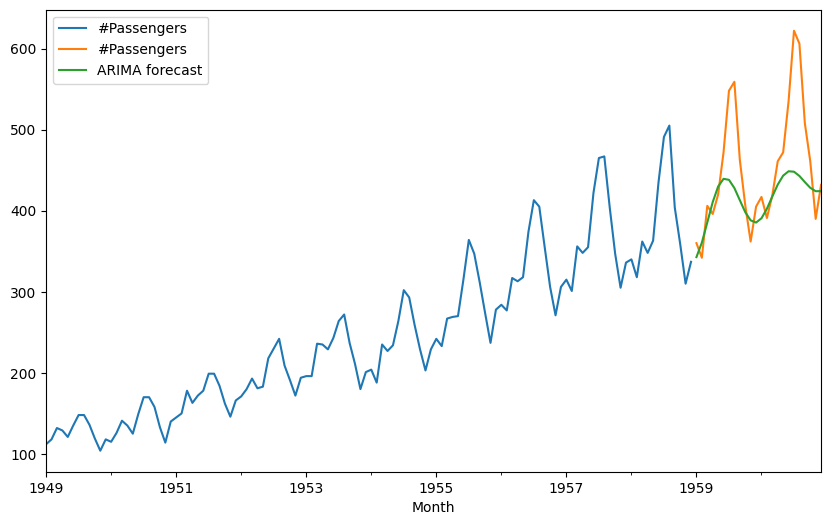

In [20]:
ax1 = train.plot()
test.plot(ax=ax1)
forecast_arima.plot(ax=ax1);

Compute some metrics.


In [21]:
print('ARIMA auto MSE:', round(mean_squared_error(test,forecast_arima),2))
print('ARIMA auto MAE:', round(mean_absolute_error(test,forecast_arima),3))

ARIMA auto MSE: 4570.22
ARIMA auto MAE: 46.928


The automatic procedure has found a model with d=1 while we found that a second-order difference was needed to satisfy the ADF test. We will try to build a similar model but using d=2 just to show an example of how to manually build an ARIMA model.

In [22]:
arima_manual = ARIMA(train, order=(2,2,2))
model_arima_manual = arima_manual.fit()
forecast_arima_manual = model_arima_manual.forecast(len(test))
forecast_arima_manual = pd.DataFrame(forecast_arima_manual)
forecast_arima_manual = forecast_arima_manual.rename(columns={'predicted_mean':'ARIMA forecast (manual)'})

/Users/magnus/development/education/ai_applied_to_engineering/assignment_2/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/magnus/development/education/ai_applied_to_engineering/assignment_2/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/magnus/development/education/ai_applied_to_engineering/assignment_2/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/magnus/development/education/ai_applied_to_engineering/assignment_2/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible star

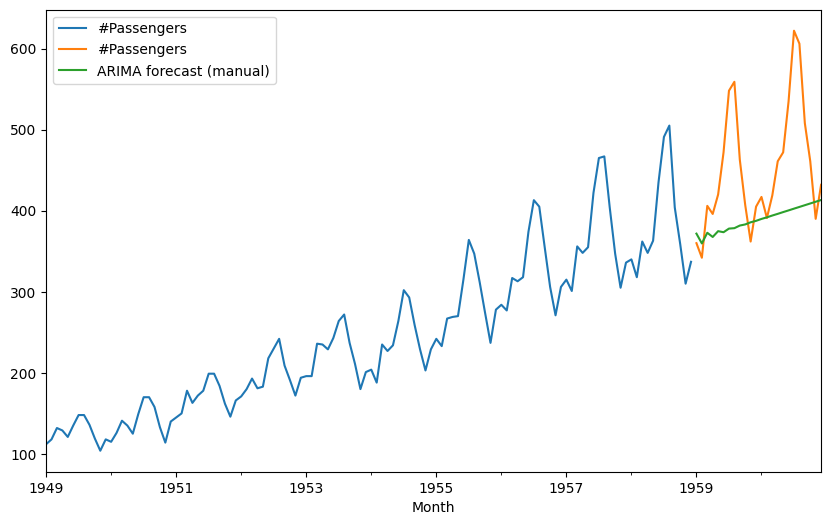

In [23]:
ax1 = train.plot()
test.plot(ax=ax1)
forecast_arima_manual.plot(ax=ax1);

In [24]:
print('ARIMA manual MSE:', round(mean_squared_error(test,forecast_arima_manual),2))
print('ARIMA manual MAE:', round(mean_absolute_error(test,forecast_arima_manual),3))

ARIMA manual MSE: 8966.05
ARIMA manual MAE: 69.647


Note that manually finding the best parameters is not always easy. Using the ADF test we were overdifferencing the series. Sometimes further work is needed in order to confirm the results from these tests.

Looking at the time series decomposition we can observe that the data shows a seasonal pattern. We apply again `auto_arima` but using the parameters to indicate seasonality and assuming a number of periods m=12 (a full year).


In [25]:
model_arima_season = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12)
model_arima_season.fit(train)
forecast_arima_season = model_arima_season.predict(n_periods=len(test))
forecast_arima_season = pd.DataFrame(forecast_arima_season,index = test.index,columns=['ARIMA forecast (seasonal)'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.750, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.31 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.04 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.20 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.13 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.07 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

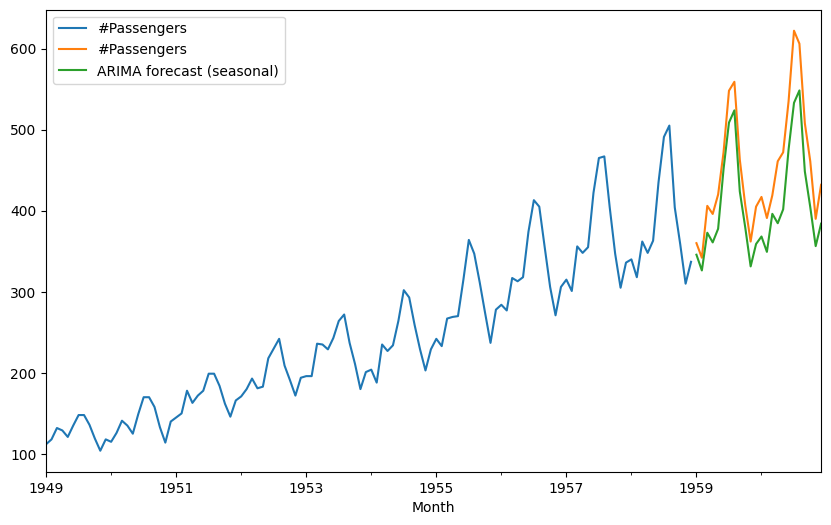

In [26]:
ax1 = train.plot()
test.plot(ax=ax1)
forecast_arima_season.plot(ax=ax1);

In [27]:
print('ARIMA seasonal MSE:', round(mean_squared_error(test,forecast_arima_season),2))
print('ARIMA seasonal MAE:', round(mean_absolute_error(test,forecast_arima_season),3))

ARIMA seasonal MSE: 2230.33
ARIMA seasonal MAE: 43.465


## PRACTICE YOURSELF

Look at this link and search for the "Lag features" section. Apply this method to trasform the problem into a classical machine learning problem and apply one or more regression/s method/s.

https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/